In [2]:
import sys
import os
import shutil
import typing
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path.append(os.getcwd())
sys.path.append('..')
import chiral_client 
print(f'chiral client version: {chiral_client.version}')
# register a user at cloud.chiral.one, get the token api from the page "Profile"
user_email = os.environ['CHIRAL_USER_EMAIL']
token_api = os.environ['CHIRAL_TOKEN_API']

user_email = 'wpqqujdd4by7q8ovmuw6l8wj3w6uhho6'
token_api = 'lvb8qltcz3x8ehyiuad36rdnz8x8p00c'

def create_client() -> chiral_client.Client:
    chiral_computing_host = "127.0.0.1"
    chiral_computing_port = "30001"
    return chiral_client.Client(user_email, token_api, chiral_computing_host, chiral_computing_port)

cc = create_client()

chiral client version: 0.3.0


In [3]:
def create_client() -> chiral_client.Client:
    chiral_computing_host = "api.chiral.one"
    chiral_computing_port = "20000"
    return chiral_client.Client(user_email, token_api, chiral_computing_host, chiral_computing_port)

cc = create_client()

# Gromacs Tutorial -  Lysozyme (egg white) in water

## Reference
- [GROMACS Tutorials by Prof. Justin A. Lemkul from Virginia Tech](http://www.mdtutorials.com/gmx/)

In [4]:
def run_step(jm: chiral_client.GromacsJobManager,
    files_upload: typing.List[str], files_input: typing.List[str], files_output: typing.List[str],
    command: str, args: str, prompts: str,
    data_dir: str, local_dir: str
):
    for filename in files_upload:
        shutil.copy(f'{data_dir}/{filename}', f'{local_dir}/{filename}')
    jm.upload_files(cc, files_upload)

    job_id = jm.submit_job(cc, command, args, prompts, files_input, files_output)
    print(f'Job {job_id} created for gromacs command\n {command} {args} with prompts {prompts}')
    cc.wait_until_completion(job_id)
    (output, error) = jm.get_output(cc, job_id)
    assert len(output) > -1
    assert error == '', f'error: {error}'
    jm.download_files(cc, files_output)
    for filename in files_output:
        assert os.path.exists(f'{local_dir}/{filename}')
    print(f'Job {job_id} completed successfully')

def run_step_1(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = ["1AKI_clean.pdb"]
    files_input = files_upload 
    files_output = ["1AKI_processed.gro", "topol.top", "posre.itp"] 
    command = 'pdb2gmx'
    args = '-f 1AKI_clean.pdb -o 1AKI_processed.gro -water spce'
    prompts = '15'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_2(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ["1AKI_processed.gro"]
    files_output = ["1AKI_newbox.gro"] 
    command = 'editconf'
    args = '-f 1AKI_processed.gro -o 1AKI_newbox.gro -c -d 1.0 -bt cubic'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_3(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['1AKI_newbox.gro', 'topol.top']
    files_output = ['1AKI_solv.gro', 'topol.top'] 
    command = 'solvate'
    args = '-cp 1AKI_newbox.gro -cs spc216.gro -o 1AKI_solv.gro -p topol.top'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_4(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = ['ions.mdp']
    files_input = ['ions.mdp', '1AKI_solv.gro', 'topol.top']
    files_output = ['1AKI_solv.gro', 'topol.top', 'ions.tpr'] 
    command = 'grompp'
    args = '-f ions.mdp -c 1AKI_solv.gro -p topol.top -o ions.tpr'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_5(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['ions.tpr', 'topol.top']
    files_output = ['1AKI_solv_ions.gro', 'topol.top'] 
    command = 'genion'
    args = '-s ions.tpr -o 1AKI_solv_ions.gro -p topol.top -pname NA -nname CL -neutral'
    prompts = '13'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_6(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = ['minim.mdp']
    files_input = ['minim.mdp', '1AKI_solv_ions.gro', 'topol.top']
    files_output = ['em.tpr'] 
    command = 'grompp'
    args = '-f minim.mdp -c 1AKI_solv_ions.gro -p topol.top -o em.tpr'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_7(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['em.tpr']
    files_output = ['em.log', 'em.edr', 'em.trr', 'em.gro'] 
    command = 'mdrun'
    args = '-deffnm em'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_8(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['em.edr']
    files_output = ['potential.xvg'] 
    command = 'energy'
    args = '-f em.edr -o potential.xvg'
    prompts = '10 0'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def plot_energy(local_dir: str):
    x,y = np.loadtxt(f'{local_dir}/potential.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x,y)
    plt.title('Energy Minimization')
    plt.xlim((0, 800))
    plt.show()

def run_step_9(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = ['nvt.mdp']
    files_input = ['nvt.mdp', 'em.gro', 'topol.top', 'posre.itp']
    files_output = ['nvt.tpr'] 
    command = 'grompp'
    args = '-f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_10(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['nvt.tpr']
    files_output = ['nvt.log', 'nvt.edr', 'nvt.trr', 'nvt.gro', 'nvt.cpt'] 
    command = 'mdrun'
    args = '-deffnm nvt'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_11(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['nvt.edr']
    files_output = ['temperature.xvg'] 
    command = 'energy'
    args = '-f nvt.edr -o temperature.xvg'
    prompts = '16 0'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def plot_temperature(local_dir: str):
    x,y = np.loadtxt(f'{local_dir}/temperature.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x,y)
    plt.title('Temperature')
    plt.xlim((0, 100))
    plt.show()

def run_step_12(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = ['npt.mdp']
    files_input = ['npt.mdp', 'nvt.gro', 'nvt.cpt', 'topol.top', 'posre.itp']
    files_output = ['npt.tpr'] 
    command = 'grompp'
    args = '-f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_13(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['npt.tpr']
    files_output = ['npt.log', 'npt.edr', 'npt.trr', 'npt.gro', 'npt.cpt'] 
    command = 'mdrun'
    args = '-deffnm npt'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_14(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['npt.edr']
    files_output = ['pressure.xvg'] 
    command = 'energy'
    args = '-f npt.edr -o pressure.xvg'
    prompts = '18 0'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_15(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['npt.edr']
    files_output = ['density.xvg'] 
    command = 'energy'
    args = '-f npt.edr -o density.xvg'
    prompts = '24 0'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def plot_pressure_density(local_dir: str):
    plt.figure().set_figwidth(10)
    plt.subplot(1, 2, 1) 
    x,y = np.loadtxt(f'{local_dir}/pressure.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x, y)
    plt.title('Pressure')
    plt.suptitle('1AKI NPT Equilibration')
    plt.xlim((0, 100))
    plt.subplot(1, 2, 2) 
    x,y = np.loadtxt(f'{local_dir}/density.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x,y)
    plt.title('Density')
    plt.suptitle('1AKI NPT Equilibration')
    plt.xlim((0, 100))

    plt.show()

def run_step_16(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = ['md.mdp']
    files_input = ['md.mdp', 'npt.gro', 'npt.cpt', 'topol.top']
    files_output = ['md_0_1.tpr'] 
    command = 'grompp'
    args = '-f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_0_1.tpr'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_17(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr']
    files_output = ['md_0_1.xtc', 'md_0_1.log'] 
    command = 'mdrun'
    args = '-deffnm md_0_1 -nb gpu'
    prompts = ''
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_18(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr', 'md_0_1.xtc']
    files_output = ['md_0_1_noPBC.xtc'] 
    command = 'trjconv'
    args = '-s md_0_1.tpr -f md_0_1.xtc -o md_0_1_noPBC.xtc -pbc mol -center'
    prompts = '1 0'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_19(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr', 'md_0_1_noPBC.xtc']
    files_output = ['rmsd.xvg'] 
    command = 'rms'
    args = '-s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg -tu ns'
    prompts = '4 4'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_20(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['em.tpr', 'md_0_1_noPBC.xtc']
    files_output = ['rmsd_xtal.xvg'] 
    command = 'rms'
    args = '-s em.tpr -f md_0_1_noPBC.xtc -o rmsd_xtal.xvg -tu ns'
    prompts = '4 4'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def run_step_21(jm: chiral_client.GromacsJobManager, data_dir: str, local_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr', 'md_0_1_noPBC.xtc']
    files_output = ['gyrate.xvg'] 
    command = 'gyrate'
    args = '-s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg'
    prompts = '1'
    run_step(jm, files_upload, files_input, files_output, command, args, prompts, data_dir, local_dir)

def plot_rmsd_gyration(local_dir: str):
    plt.figure().set_figwidth(10)
    plt.subplot(1, 2, 1) 
    x_1, y_1 = np.loadtxt(f'{local_dir}/rmsd.xvg', comments=['#', '@'], unpack=True)
    x_2, y_2 = np.loadtxt(f'{local_dir}/rmsd_xtal.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x_1, y_1)
    plt.plot(x_2, y_2)
    plt.title('RMSD')
    plt.suptitle('1AKI Backbone')
    plt.xlim((0, 1))
    plt.subplot(1, 2, 2) 
    x_1, y_1, _, _, _ = np.loadtxt(f'{local_dir}/gyrate.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x_1, y_1)
    plt.title('Radius of gyration')
    plt.suptitle('1AKI Unrestrained MD')
    plt.xlim((0, 1))
    plt.show()

Job ndc5wmg5va0g53yuz3okrk69e2odppty created for gromacs command
 rms -s em.tpr -f md_0_1_noPBC.xtc -o rmsd_xtal.xvg -tu ns with prompts 4 4
Job ndc5wmg5va0g53yuz3okrk69e2odppty completed successfully
Job x8jyghv9fln8plgxr5tacx6uly9ib9gu created for gromacs command
 gyrate -s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg with prompts 1
Job x8jyghv9fln8plgxr5tacx6uly9ib9gu completed successfully


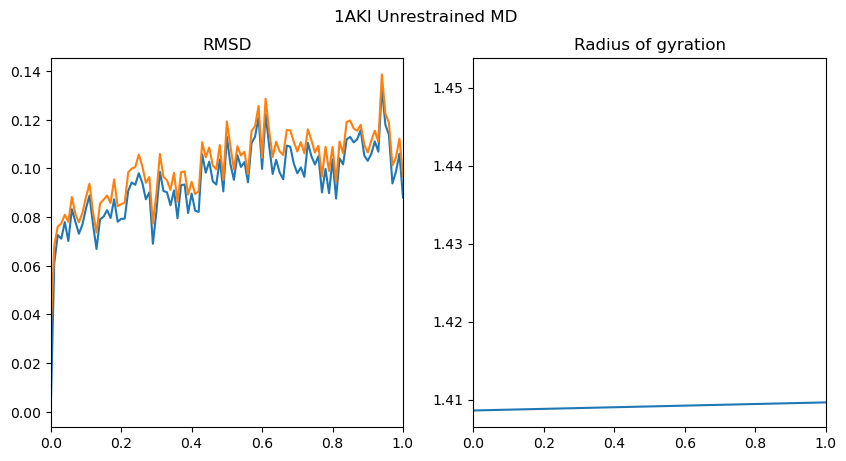

Simulation lysozyme Completes!


In [5]:
simulation_id = 'lysozyme'
data_dir = f'./data/gromacs/{simulation_id}'
local_dir = simulation_id
if os.path.exists(local_dir):
    shutil.rmtree(local_dir)
os.mkdir(local_dir)

job_mgr = chiral_client.GromacsJobManager(simulation_id, local_dir, cc)
job_mgr.clear_files(cc)

run_step_1(job_mgr, data_dir, local_dir)
run_step_2(job_mgr, data_dir, local_dir)
run_step_3(job_mgr, data_dir, local_dir)
run_step_4(job_mgr, data_dir, local_dir)
run_step_5(job_mgr, data_dir, local_dir)
run_step_6(job_mgr, data_dir, local_dir)
run_step_7(job_mgr, data_dir, local_dir)
clear_output(wait=True)
run_step_8(job_mgr, data_dir, local_dir)
plot_energy(local_dir)
run_step_9(job_mgr, data_dir, local_dir)
run_step_10(job_mgr, data_dir, local_dir)
clear_output(wait=True)
run_step_11(job_mgr, data_dir, local_dir)
plot_temperature(local_dir)
run_step_12(job_mgr, data_dir, local_dir)
run_step_13(job_mgr, data_dir, local_dir)
clear_output(wait=True)
run_step_14(job_mgr, data_dir, local_dir)
run_step_15(job_mgr, data_dir, local_dir)
plot_pressure_density(local_dir)
run_step_16(job_mgr, data_dir, local_dir)
run_step_17(job_mgr, data_dir, local_dir)
run_step_18(job_mgr, data_dir, local_dir)
run_step_19(job_mgr, data_dir, local_dir)
clear_output(wait=True)
run_step_20(job_mgr, data_dir, local_dir)
run_step_21(job_mgr, data_dir, local_dir)
plot_rmsd_gyration(local_dir)

shutil.rmtree(local_dir)
print(f'Simulation {simulation_id} Completes!')
